# II. Time Series Models: Theory and Foundations


## II.1. Introduction

### II.1.A. What's forecasting about?

Forecasting involves the prediction of some future event.

Forecasting problems are commonly classified based on the time horizon of the prediction:

-   **Short-term forecasting**: This involves predictions a few time periods (days, weeks, or months) into the future.

-   **Medium-term forecasting**: This type of forecasting typically covers a horizon from one to two years into the future.

-   **Long-term forecasting**: Long-term forecasting extends to predictions many years into the future.

Short-term and medium-term forecasting are typically based on identifying, modeling, and extrapolating patterns found in historical data.

Long-term forecasting, in contrast, is often based on expert knowledge and fundamental models.


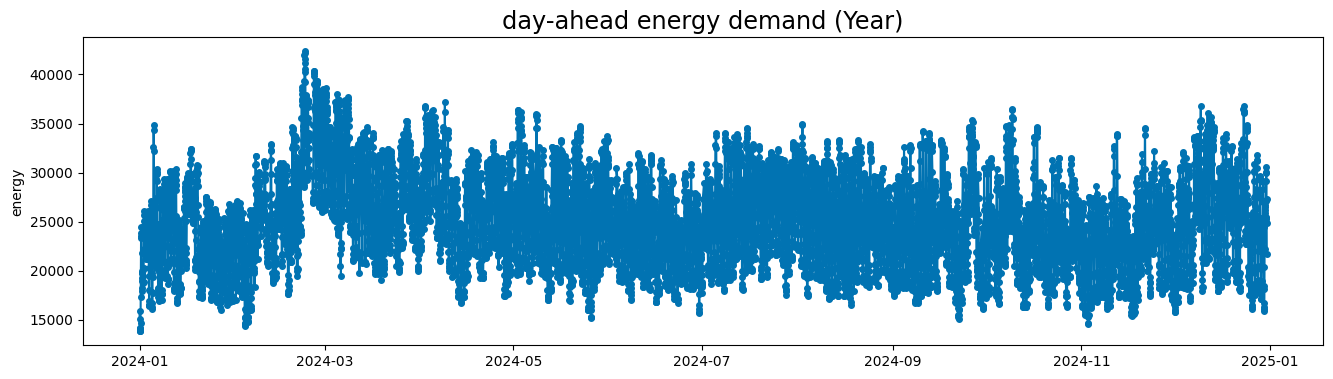

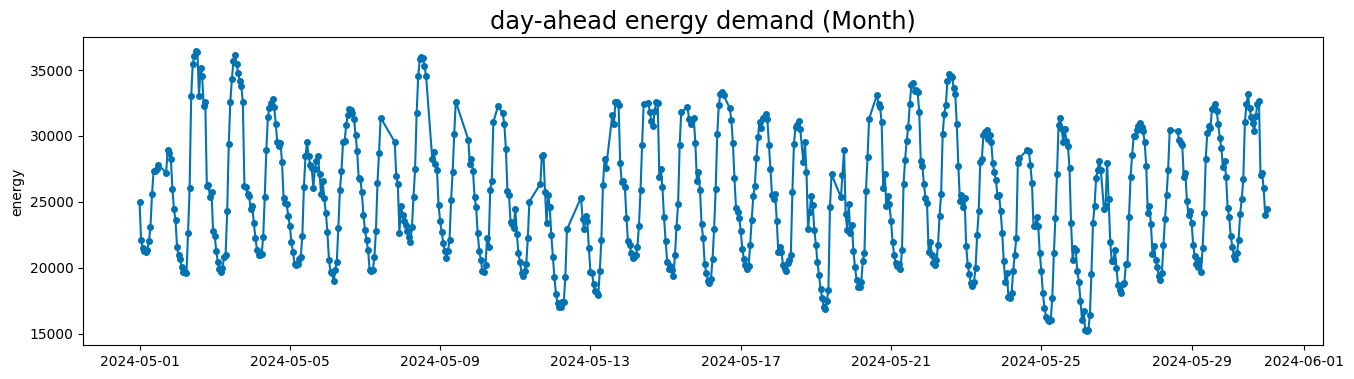

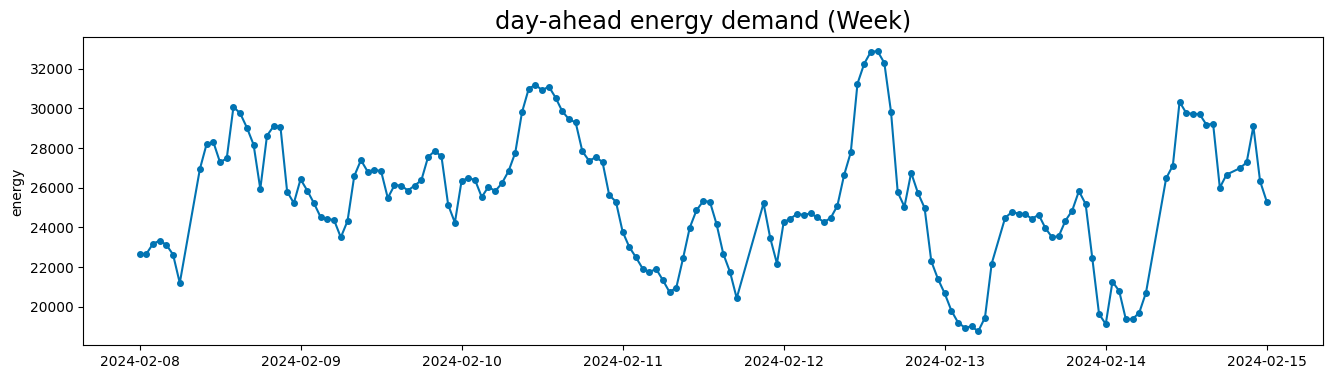

In [1]:
from utils import ExampleDataLoader, plot_series_slice

energy = ExampleDataLoader("energy").load().set_index("datetime")

energy_yr = plot_series_slice(
    energy, 
    start="2024-01-01 00:00:00", 
    stop="2024-12-31 00:00:00",
    freq="h",    
    title="day-ahead energy demand (Year)",
    return_data=True,
)

energy_month = plot_series_slice(
    energy, 
    start="2024-05-01 00:00:00", 
    stop="2024-05-31 00:00:00",
    freq="h",
    title="day-ahead energy demand (Month)",
    return_data=True,
)

energy_week = plot_series_slice(
    energy, 
    start="2024-02-08 00:00:00", 
    stop="2024-02-15 00:00:00",
    freq="h",
    title="day-ahead energy demand (Week)",
    return_data=True,
)

### II.1.B. Objectives of time series analysis & forecasting

- **Describing** the evolution of a time series.

- **Modelling** the process that has generated the time series by means of a suitable statistical model.

- **Forecasting**/Predicting future values of the time series.

- **Control**. Good  forecasts enable the analyst to take actions so as to control a given process.

### II.1.C. Forecasting taxonomy

Forecasting methods can be broadly categorized into two types:

- **Quantitative methods**: These methods are employed when sufficient information about the past is available, typically in the form of numerical time series data. They assume that the future will be similar to the past, a concept known as the continuity assumption.

- **Qualitative methods**: These methods are used when little or no quantitative information is available. They are based on expert knowledge and judgment; a well-known example is the Delphi method.

Quantitative models can be further classified into two main types:

- **Explanatory models**: These models express the variable to be forecast ($y$) as a function of other explanatory variables ($x_1, ..., x_n$) and a noise component.

$$
y = f(x_1, ..., x_n, \text{noise})
$$


- **Time series models**: These models predict the variable to be forecast ($y_t$) as a function of its own past values ($y_{t-1}, y_{t-2}, ...$) and a noise component, or potentially also incorporating explanatory variables.

    $$
    y_t = f(y_{t-1}, y_{t-2}, ..., \text{noise})
    $$

    or

    $$
    y_t = f(y_{t-1}, y_{t-2}, ..., x_t, x_{t-1}, x_{t-2}, ..., \text{noise})
    $$

In both explanatory and time series models, the observation ($y$) is considered to be composed of two components:

$$
\boxed{\quad y = \textbf{pattern} + \textbf{\color{red}{noise}}\quad}
$$


Where:

-   **pattern** = forecast

-   **noise** = uncertainty

The objective of forecasting is to separate these two components: to use the pattern for forecasting and to characterize prediction errors using the observed noise.


### I.1.D. Forecast steps (future pipeline)

The general steps involved in the forecasting process are:

1.  **Collect Data**: The foundation of any forecasting endeavor is the acquisition of relevant and high-quality historical data. This may involve gathering data from various sources and ensuring its completeness and accuracy.

2.  **Preprocess (Clean) Data**: Time series data often requires careful preprocessing to handle imperfections and inconsistencies.

    -   **Missing Values Imputation**: Gaps in the time series must be addressed. Techniques like linear interpolation, mean/median imputation, or more sophisticated methods based on time series characteristics can be employed.

    -   **Outlier Detection and Treatment**: Extreme values that deviate significantly from the typical pattern can distort forecasts. Identifying and mitigating the impact of outliers through techniques like moving average smoothing or robust statistical methods is essential.

    -   **Data Transformation**: In some cases, transformations such as logarithmic or Box-Cox transformations may be necessary to stabilize the variance or make the time series stationary.

    -   **Scaling**: Scaling the data (e.g., using min-max scaling or standardization) can be beneficial for certain modeling techniques, especially neural networks.

3.  **Feature Engineering (If Applicable)**: Depending on the forecasting model, creating new features from the existing time series can improve predictive performance.

    -   **Lagged Variables**: Including past values of the time series as predictors ($y_{t-1}$, $y_{t-2}$, etc.) is a common and powerful technique.

    -   **Rolling Statistics**: Calculating statistics over moving windows (e.g., rolling mean, rolling standard deviation) can capture local trends and variability.

    -   **Time-Based Features**: Extracting features related to time (e.g., day of the week, month of the year) can help capture seasonality.

4.  **Choose Model**: Selecting an appropriate forecasting model is critical and depends on the characteristics of the data and the forecasting task.

    -   Consider factors such as the presence of trends, seasonality, autocorrelation, and the desired forecast horizon.

    -   Evaluate a range of models, from simple methods like those discussed earlier (average, naive, seasonal naive, drift) to more complex approaches like ARIMA, exponential smoothing, or machine learning models.

5.  **Model Selection and Evaluation**: Rigorous model selection and evaluation are essential to ensure the chosen model generalizes well to unseen data.

    -   **Time Series Cross-Validation**: Unlike traditional cross-validation, time series cross-validation respects the temporal order of the data. Techniques like rolling-origin cross-validation are used to simulate forecasting at different points in time.

    -   **Evaluation Metrics**: Assess model performance using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or Mean Absolute Percentage Error (MAPE).

    -   **Statistical Significance Tests**: When comparing multiple models, statistical tests can help determine if the differences in performance are statistically significant.

6.  **Fit Parameters**: Once a model is selected, its parameters must be estimated using the training data.

    -   This often involves optimization techniques to minimize the chosen error metric.

7.  **Model Validation**: After training, it's crucial to validate the model on a separate validation set to ensure it generalizes well and is not overfitting.

8.  **Forecasting**: With a validated model, forecasts can be generated for the desired future time periods.

9.  **Uncertainty Estimation**: Providing forecasts without an estimate of their uncertainty can be misleading.

    -   Techniques like prediction intervals, bootstrapping, or simulation can be used to quantify the range of possible future outcomes.

10. **Monitoring and Model Updating**: Forecasting models should be continuously monitored and updated as new data becomes available.

    -   The performance of the model may degrade over time due to changes in the underlying patterns of the time series.



## II.2. Naïve forecasters

We introduce some basic, yet important, forecasting methods.

In [2]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.datasets import load_airline

#### II.2.A. Naïve average method

The average method forecasts all future values as the mean of the historical data.

$$
\hat{y}_t = \bar{y} = \frac{1}{T} \sum_{t=1}^{T} y_t
$$

where $\hat{y}_t$ is the forecast at time $t$, $\bar{y}$ is the mean of the historical data, and $T$ is the number of historical data points.

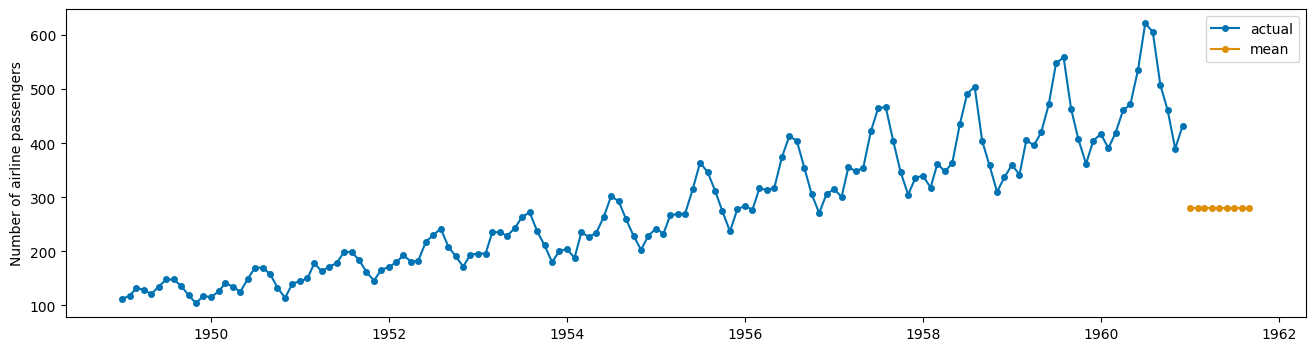

In [3]:
y = load_airline()

forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_mean_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_mean_pred, labels=["actual", "mean"])

### II.2.B. Naïve last-value method

The naive forecaster predicts the next value to be equal to the last observed value.

$$
\hat{y}_{t} = y_{t-1}
$$

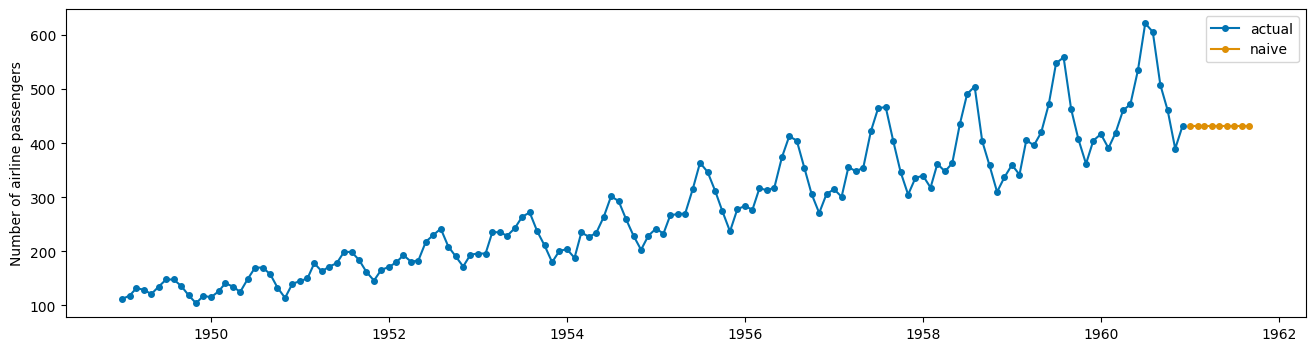

In [4]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_naive_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_naive_pred, labels=["actual", "naive"])

### II.2.C. Seasonal naïve method

The seasonal naive forecaster predicts the next value to be equal to the value from the same season in the previous cycle.

$$
\hat{y}_t = y_{t-m}
$$

where $m$ is the seasonal period.

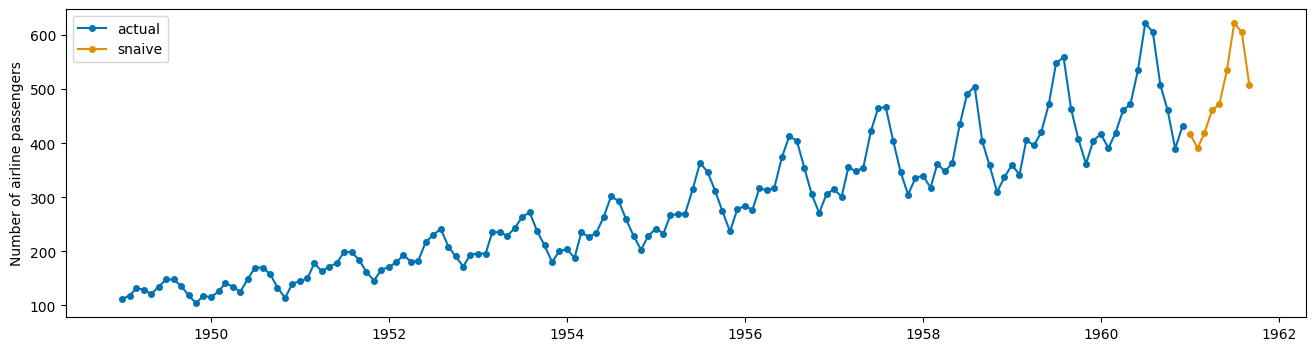

In [5]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_snaive_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_snaive_pred, labels=["actual", "snaive"])

### II.2.D. Naïve drift method

The drift method is a variation of the naive method that allows the forecast to increase or decrease over time.

$$\hat{y}_t = y_{t-1} + \frac{y_{t-1} - y_{t-k}}{k}
$$where $k$ is the number of periods over which the drift is calculated.

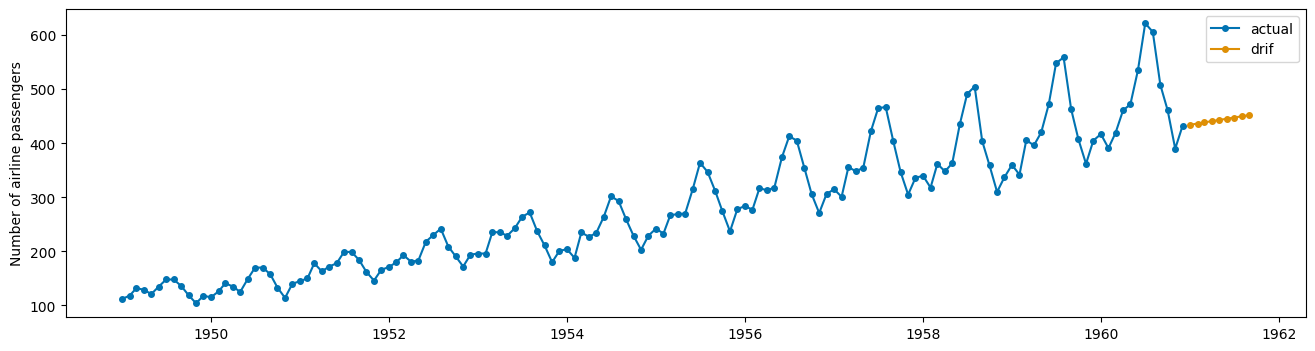

In [6]:
y = load_airline()

# `k` would be regulated via `window_length` parameter
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_drift_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_drift_pred, labels=["actual", "drif"])

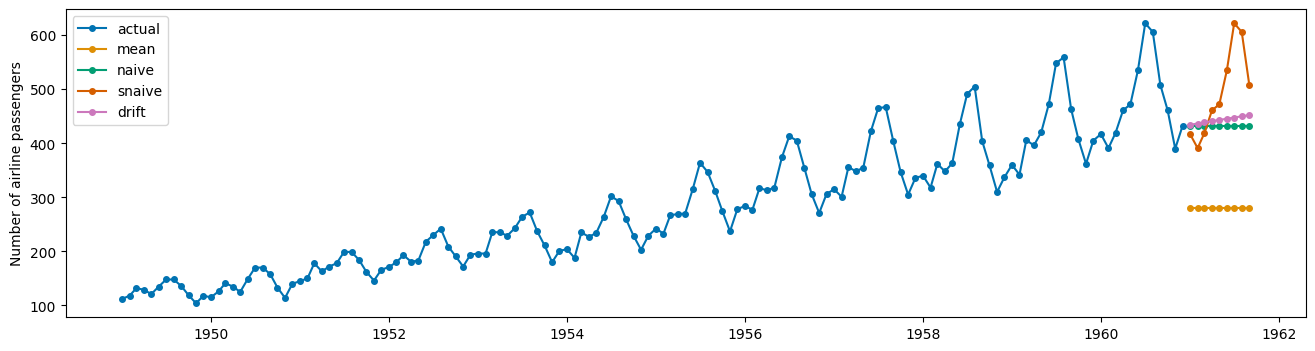

In [7]:
series = [y, y_mean_pred, y_naive_pred, y_snaive_pred, y_drift_pred]
labels = ["actual", "mean", "naive", "snaive", "drift"]
fig, ax = plot_series(*series, labels=labels)

### II.2.E Forecast error

The forecast error ($e_t$) is the difference between the actual value ($y_t$) and the forecast value ($\hat{y}_t$):

$$
e_t = y_t - \hat{y}_t
$$

Residuals are useful in checking whether a model has adequately captured the information in the data.

A good forecasting method will yield residuals with the following properties:

- The **residuals are uncorrelated**. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

- The **residuals have zero mean**. If the residuals have a mean other than zero, then the forecasts are biased.

In [8]:
from utils import plot_residuals

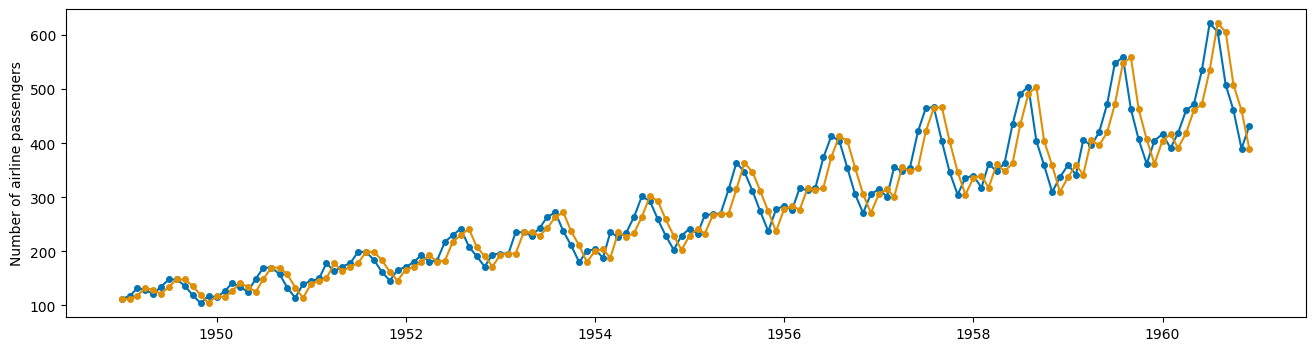

In [9]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

# Forecast for the entire historical period
fh = ForecastingHorizon(y.index, is_relative=False)
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y,y_pred)

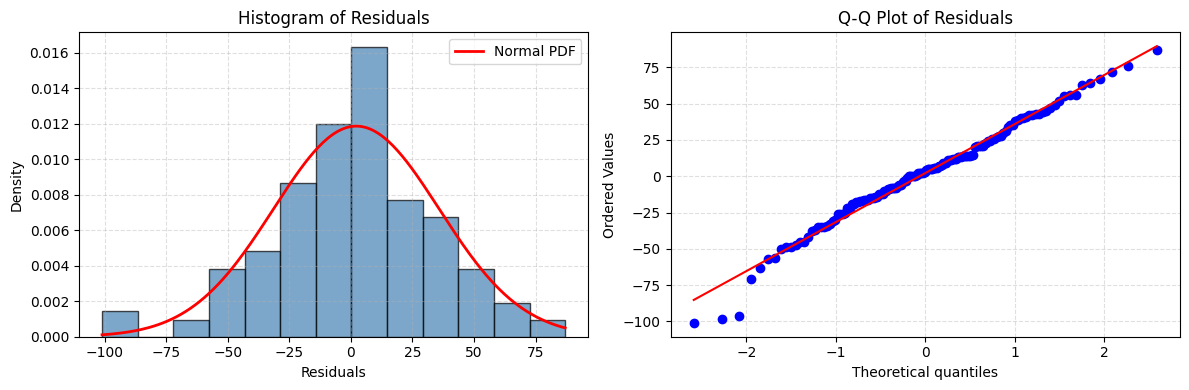

In [10]:
residuals = y - y_pred
plot_residuals(residuals)

### Assessing normality of residuals: Visual criteria

Normality of residuals is an important assumption for some time series analyses. Visual methods help to quickly assess deviations from normality.

**Histogram:**

   -   **Symmetry:** The histogram should be approximately symmetric, resembling a bell curve.
   -   **Skewness:**
        -   Right-skewed (long tail to the right): Indicates more smaller residuals.
        -   Left-skewed (long tail to the left): Indicates more larger residuals.
   -   **Kurtosis:**
        -   Mesokurtic: Similar tail behavior to a normal distribution.
        -   Leptokurtic: Heavier tails (more extreme residual values).
        -   Platykurtic: Lighter tails (fewer extreme residual values).
   -   **Normal Curve Fit:** Compare the histogram's shape to an overlaid normal distribution curve; a close fit suggests normality.

**Q-Q Plot (Quantile-Quantile Plot):**

   -   **Linearity:** Residuals should fall closely along the straight diagonal line.
   -   **Deviations:**
        -   End deviations: Indicate non-normality in the distribution's tails (skewness/kurtosis).
        -   Curvature: Suggests skewness.
        -   S-shape: Often indicates skewness.

**Note**: Perfect normality is rare in practice. The severity of deviations and their impact on the analysis should be considered.

**General guideline**: Minor wiggles around the line in a `Q-Q plot are common, especially with smaller sample sizes. Focus on systematic and significant deviations. The Q-Q plot is often considered a more reliable visual tool for assessing normality than a histogram, particularly for detecting deviations in the tails.

### II.2.F Bootstrapping for uncertainty estimation

Bootstrapping is a resampling technique used to estimate the uncertainty of forecasts. It provides a way to generate prediction intervals without relying on strong distributional assumptions about the residuals.

The process involves:

1.  Fitting a forecasting model to the historical time series data.

2.  Calculating the residuals.

3.  Repeatedly resampling the residuals with replacement to create multiple **bootstrapped** residual sets.

4.  For each bootstrapped residual set, generating a new set of forecasts by adding the resampled residuals to the model's point forecasts.

5.  Calculating statistics (e.g., quantiles) across the bootstrapped forecasts to estimate prediction intervals.

In [11]:
from utils import BootstrappedForecaster, plot_forecast_with_intervals

In [12]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last", sp=10)
forecaster.fit(y)

# Forecast for the entire historical period
fh = ForecastingHorizon(range(1,20))  

y_pred, boot_preds = BootstrappedForecaster(forecaster).predict(y, fh)

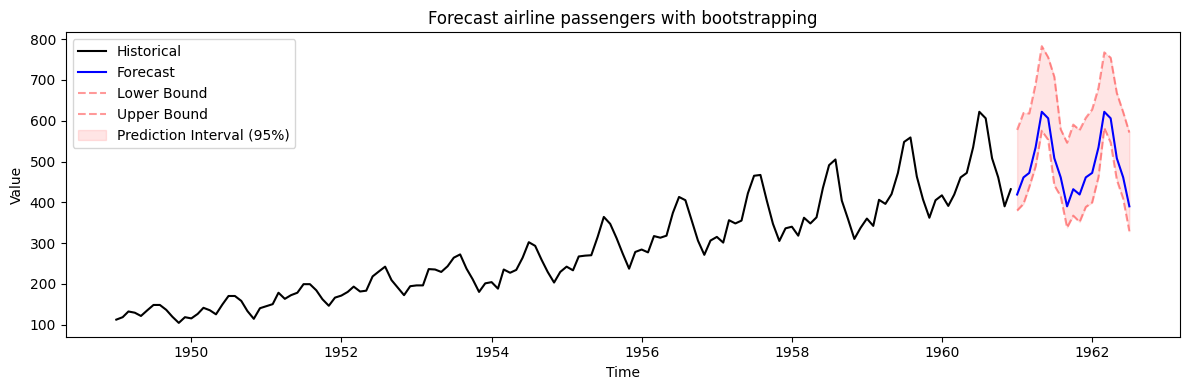

In [13]:
plot_forecast_with_intervals(
    actual=y,
    forecast=y_pred,
    lower=boot_preds.quantile(0.025, axis=1),
    upper=boot_preds.quantile(0.975, axis=1),
    title="Forecast airline passengers with bootstrapping"
)

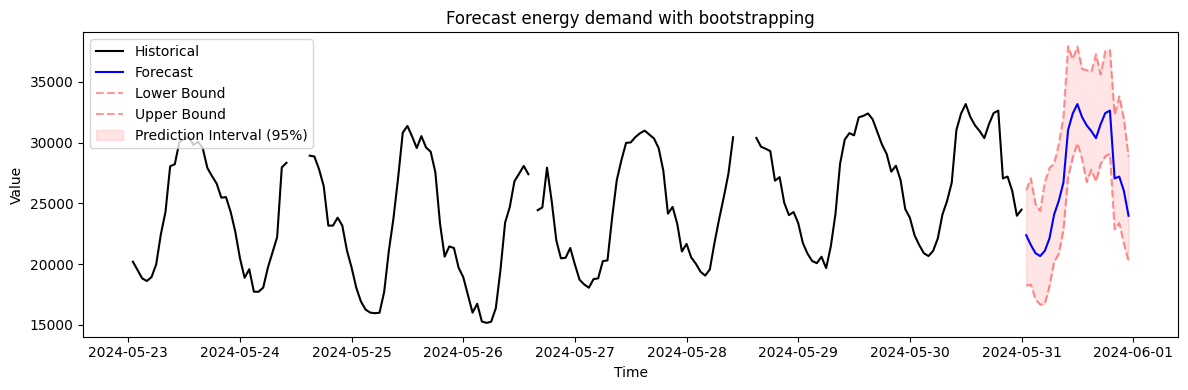

In [14]:
y = energy_month["energy"].asfreq("h")

forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y)

fh = ForecastingHorizon(range(1,24), is_relative=True)

y_pred, boot_preds = BootstrappedForecaster(forecaster).predict(y, fh)

plot_forecast_with_intervals(
    actual=y[-24*8:],
    forecast=y_pred,
    lower=boot_preds.quantile(0.025, axis=1),
    upper=boot_preds.quantile(0.975, axis=1),
    title="Forecast energy demand with bootstrapping"
)

## II.3. Interlude: Basic transformations and adjustments

Before applying forecasting models, it is often necessary to preprocess the data through transformations and adjustments. The primary goals of these operations are to:
- **Stabilize the variance**, i.e., to make the distribution of the series more **normal-like**,
- account for **external factors** that are not part of the underlying pattern of the time series itself.

### II.3.A. Mathematical Transformations

Simple mathematical transformations can often linearize relationships and stabilize variance. 
A series with a **variance that grows over time** can be difficult to model. 
Applying a function like a **logarithm** or **square root** can often make the variance more constant, satisfying assumptions for many classical models.

-   **Logarithm (`log`)**: Particularly effective for series where the variance grows proportionally to the mean. It helps to stabilize the variance and linearize exponential growth trends.
-   **Square Root (`sqrt`), Cube Root (`cbrt`)**: Milder transformations than the logarithm, useful for reducing right-skewness and stabilizing variance.
-   **Inverse (`1/y`)**: A strong transformation, not as commonly used in forecasting but can be useful in specific contexts.


In [15]:
import numpy as np
from matplotlib import pyplot as plt

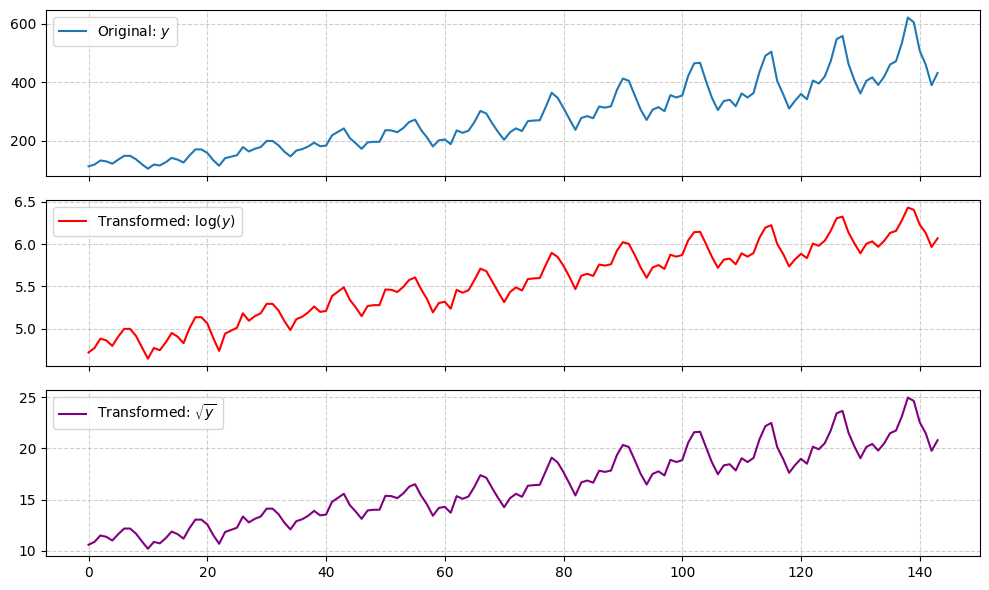

In [16]:
y = load_airline()

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for ax, y_ts, opts in zip(
    axes,
    [y, np.log(y), np.sqrt(y)],
    [
        {"label": r'Original: $y$'}, 
        {"label": r'Transformed: $\log(y)$', "color": "red"}, 
        {"label": r'Transformed: $\sqrt{y}$', "color": "purple"},
    ],
):
    ax.plot(y_ts.values, **opts)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### Box-Cox transformation

The Box-Cox transformation is a **more powerful** and **generalized** power transformation that automatically finds an optimal parameter, $\lambda$ (lambda), to transform a series. Its goal is to find the best transformation to make the data more closely resemble a normal distribution and to stabilize its variance.

The transformation is defined as:
$$
y^{(\lambda)} = 
\begin{cases}
\ln(y) & \text{if } \lambda = 0,\\
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0. 
\end{cases}
$$

We can implement our own transformer, and use it, as presented below:

In [17]:
from utils import MyBoxCoxTransformer

y = load_airline()

bc_transformer = MyBoxCoxTransformer()
y_transformed_optimal = bc_transformer.fit_transform(y)

print(f"\nOptimal Lambda found by scipy: {bc_transformer.alpha:.4f}\n")


Optimal Lambda found by scipy: 0.1480



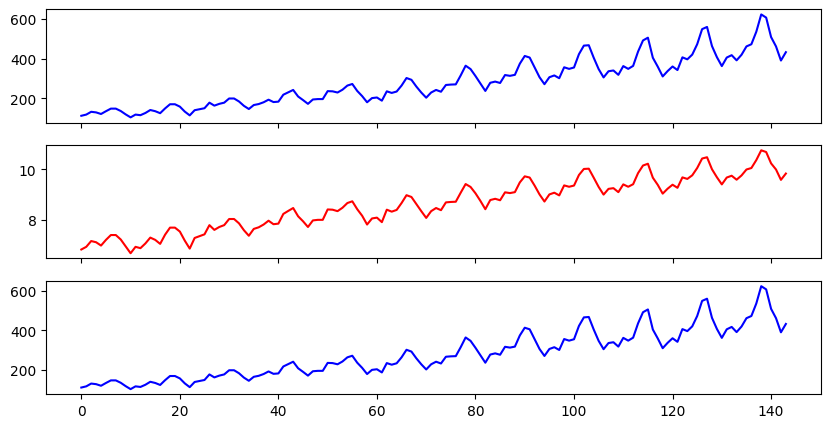

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

axes[0].plot(y.values, color="blue")
axes[1].plot(y_transformed_optimal, color="red")
axes[2].plot(bc_transformer.inverse_transform(y_transformed_optimal), color="blue")

One of the peculiarities of time-series transformations is that if we train a model using a transformed series, we will **need to invert the transformations** carried out, and that can be non-trivial. This is one of the reasons to introduce `sktime` transformers, as we will see in a bit.

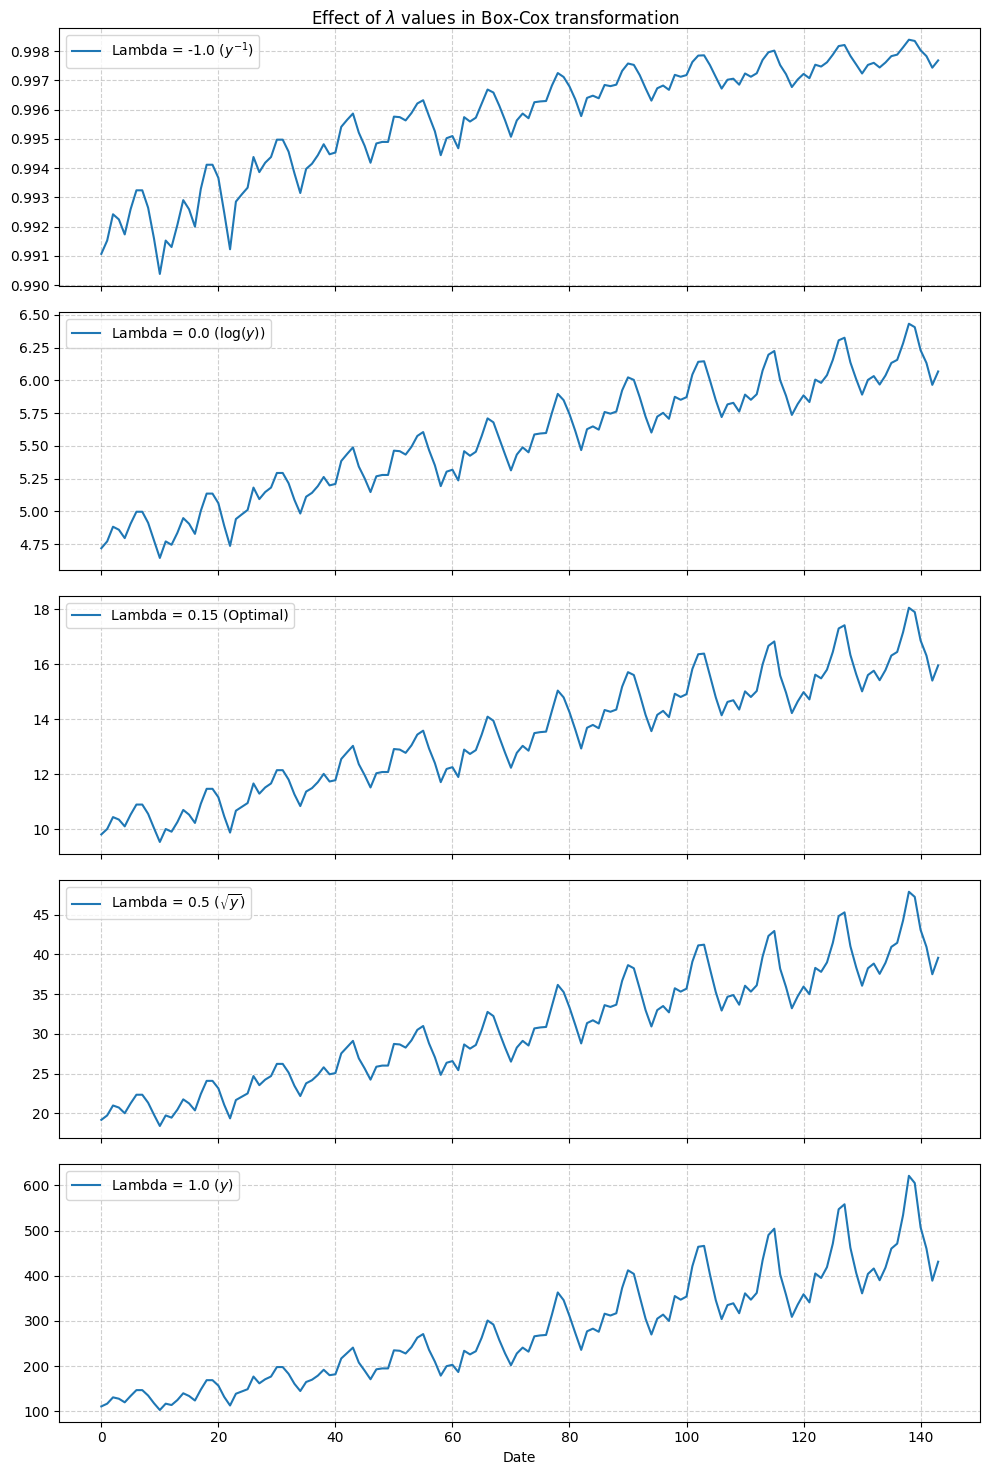

In [19]:
from matplotlib import pyplot as plt

lambda_values = [-1.0, 0.0, 0.28, 0.5, 1.0]
labels = [
    r'Lambda = -1.0 ($y ^{-1}$)',
    r'Lambda = 0.0 ($\log(y)$)',
    f'Lambda = {bc_transformer.alpha:.2f} (Optimal)',
    r'Lambda = 0.5 ($\sqrt{y}$)',
    r'Lambda = 1.0 ($y$)'
]

fig, axes = plt.subplots(len(lambda_values), 1, figsize=(10, 15), sharex=True)
fig.suptitle(r'Effect of $\lambda$ values in Box-Cox transformation', fontsize=12)

for i, value in enumerate(lambda_values):
    y_transformed = MyBoxCoxTransformer(alpha=value).transform(y)
    axes[i].plot(y_transformed, label=labels[i])
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

#### Time series transformers with `sktime`

We can use pre-built transformers which are already tested in the same way we do with `sklearn` transformers.
**Scikit Time** (or `sktime`) comes with a [bunch of transformers](https://www.sktime.net/en/stable/examples/03_transformers.html) (built-in and tested thoroughly!) so that we do not have to code them by ourselves. Also with the convenience that they will be very easily integrated in forecasting pipelines, as we will see later. Example:

In [20]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

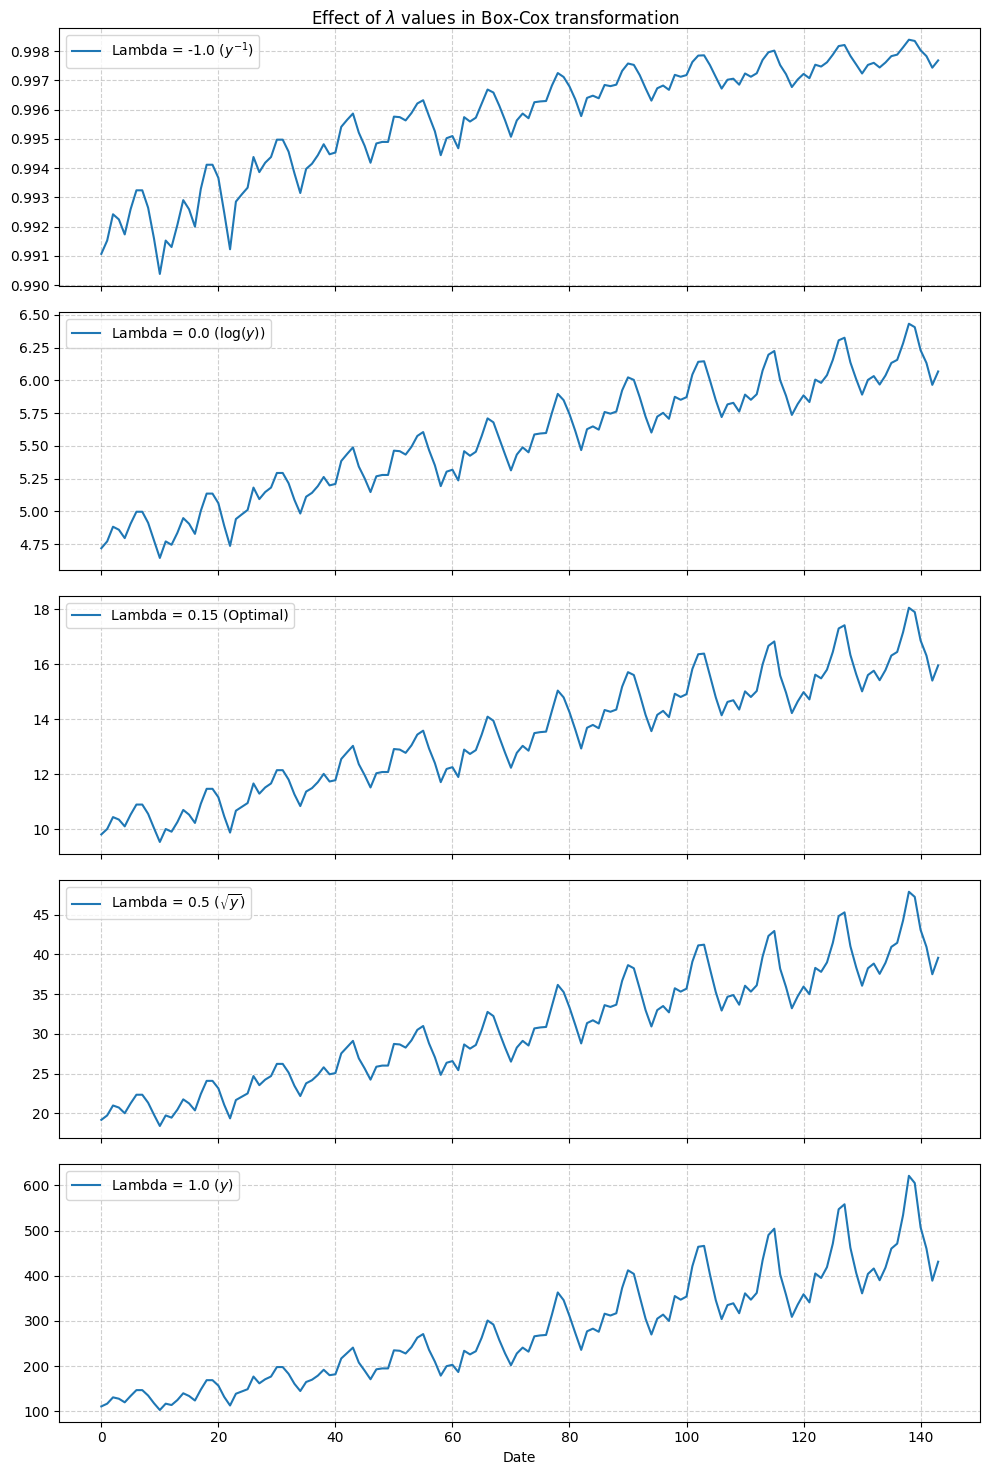

In [21]:
fig, axes = plt.subplots(len(lambda_values), 1, figsize=(10, 15), sharex=True)
fig.suptitle(r'Effect of $\lambda$ values in Box-Cox transformation', fontsize=12)

for i, l in enumerate(lambda_values):
    transformer = BoxCoxTransformer(method="fixed",  lambda_fixed=l)
    y_transformed = transformer.fit_transform(y)
    axes[i].plot(y_transformed.values, label=labels[i])
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

### II.3.B. Calendar Adjustments

Sometimes, variations in a time series are due to systemic, calendar, or economic effects rather than the underlying pattern of interest. Adjusting for these can lead to better forecasts.

Data aggregated over months can be misleading because months have different numbers of days (from 28 to 31). This can introduce artificial variation. This effect can be corrected by adjusting the data to represent an average month's length.

#### Example: Adjusting monthly electricity consumption - scale the consumption by the number of days in month

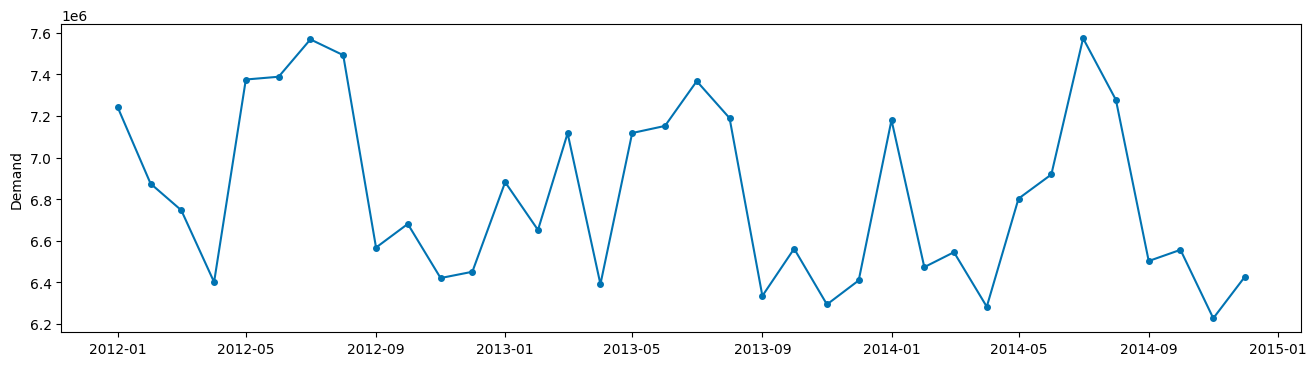

In [22]:
import pandas as pd

monthly_demand = ExampleDataLoader("monthly_demand").load()
monthly_demand.set_index(["Date"], inplace=True)

fig, ax = plot_series(monthly_demand["Demand"])

##### Manual adjustment (prone to future errors)

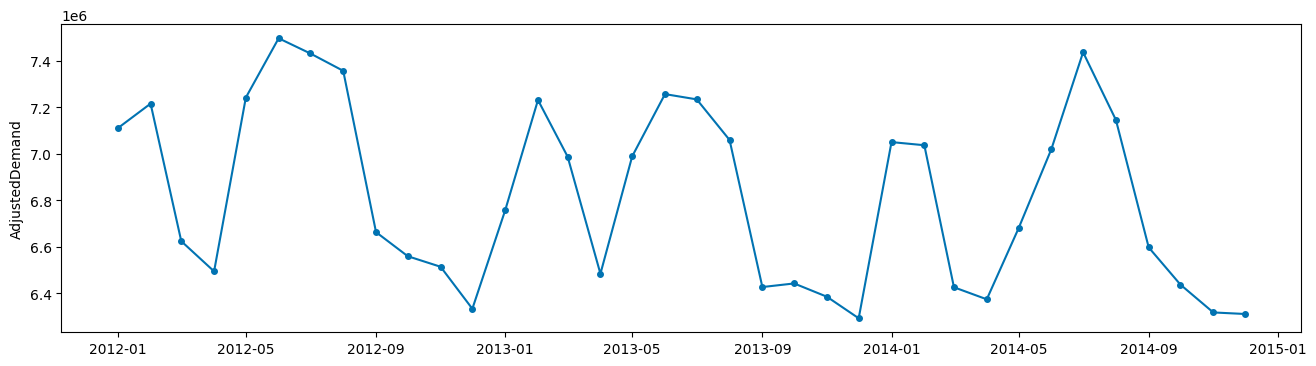

In [23]:
monthly_demand.reset_index(names=["Date"], inplace=True)

monthly_demand["DaysInMonth"] = monthly_demand["Date"].dt.days_in_month
avg_days_per_month = 365.25 / 12
monthly_demand["AdjustedDemand"] = (monthly_demand["Demand"] / monthly_demand["DaysInMonth"]) * avg_days_per_month

monthly_demand.set_index(["Date"], inplace=True)
fig, ax = plot_series(monthly_demand["AdjustedDemand"])

##### Using custom Time Series transfomers

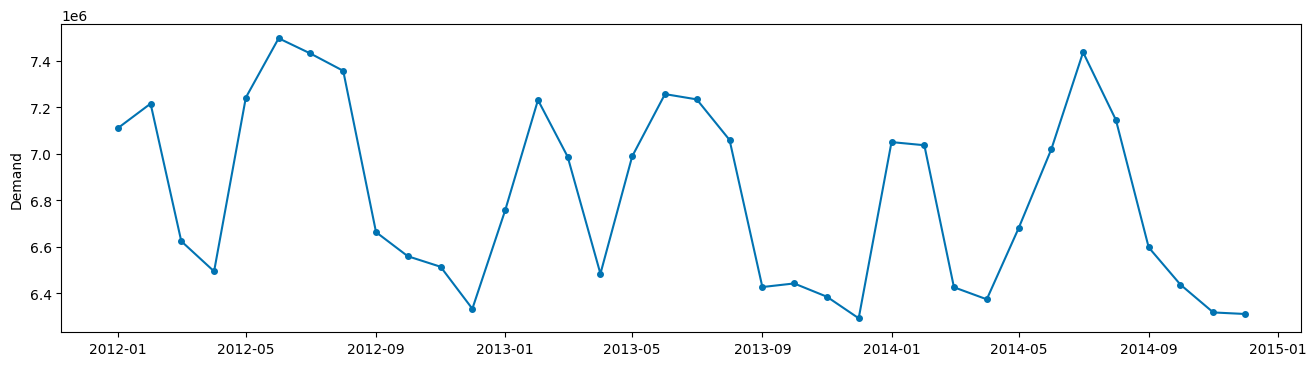

In [24]:
from utils import MyMonthlyAdjuster

monthly_demand = ExampleDataLoader("monthly_demand").load()
monthly_demand.set_index(["Date"], inplace=True)

fig, ax = plot_series(MyMonthlyAdjuster().fit_transform(monthly_demand))

### II.3.C. Economic Adjustments

Some useful adjustments needed when dealing with economic data are (amongst many others):

#### Inflation

When forecasting series involving monetary values (e.g., prices, revenue), it is crucial to account for inflation. This is done by deflating the series with a price index (like the Consumer Price Index, CPI) to get values in "real" or "constant" terms.

$$\text{real\_value} = (\text{nominal\_value} / \text{price\_index}) * 100$$

#### Population Growth

For series influenced by population size (e.g., number of public transport users, total sales of a product), it is often better to forecast a **per-capita** value. This removes the variation simply caused by a changing population.

  
$$\text{per\_capita\_value} = \text{total\_value} / \text{population}$$

Beyond inflation and population, several other external factors can distort the underlying patterns in economic data. Adjusting for these effects is a crucial step in building accurate and interpretable models.

#### Trading day and working day adjustment

* **Concept**: Months and quarters have a varying number of trading days or working days. For example, February has fewer working days than March, and a given quarter might have more weekends than another. This can cause significant variation in production or sales data that has nothing to do with economic health.

* **Example Series**: `Industrial Production`, `Exports/Imports`, `Monthly Retail Sales`.

* **Method of Adjustment**:
    * **Direct Scaling**: Divide the monthly total by the number of trading days in that month to get a "per-day" rate. This can then be multiplied by an average number of trading days per month to create an adjusted series.
    * **Regression Approach**: Use the number of trading days as an explanatory variable in a regression model (like ARIMA with regressors, known as REGARIMA). The model will estimate the effect of an additional trading day and effectively account for it.

#### Holiday effects

* **Concept**: While fixed holidays like Christmas contribute to standard seasonality, **moving holidays** like Easter can create major analytical challenges. Easter can fall in either March (Q1) or April (Q2), shifting a significant amount of economic activity (e.g., retail sales, travel) between quarters from one year to the next.
  
* **Example Series**: `Retail Sales` (especially for candy, clothing), `Tourist Arrivals`, `Air Passenger Traffic`.

  
* **Method of Adjustment**:
    * **Dummy/Indicator Variables**: Create a dummy variable that is `1` for the period affected by the moving holiday (e.g., the 7 days leading up to Easter) and `0` otherwise. This variable can then be included as a regressor in the model to capture the holiday's specific impact.

#### Exchange rate adjustment

* **Concept**: For any data involving international transactions, fluctuations in currency exchange rates can obscure underlying business performance. A company's revenue from foreign sales might increase in its home currency simply because the foreign currency strengthened, even if sales volume was flat.

* **Example Series**: `Export/Import Values`, `Revenue of a Multinational Corporation`, `Foreign Direct Investment (FDI)`.

* **Method of Adjustment**:
    * **Constant Exchange Rate**: Convert all foreign currency amounts to a single home currency using a constant exchange rate, typically the average rate from a fixed base year. This removes the effect of currency volatility.
    * **Analyze in Local Currency**: Analyze performance within a country or region in its own local currency before aggregating results.



#### Seasonal adjustment

* **Concept**: This is a fundamental and widespread adjustment in economics. It goes beyond just modeling seasonality and involves removing the seasonal component entirely to better highlight the underlying trend-cycle of the series. Most major government economic statistics (like GDP or unemployment) are presented in a seasonally adjusted (SA) form.
    
* **Example Series**: `Gross Domestic Product (GDP)`, `Unemployment Rate`, `Housing Starts`.
    
* **Method of Adjustment**:
    * **Standardized Programs**: Use well-established statistical programs like **X-13-ARIMA-SEATS** (developed by the U.S. Census Bureau) or methods like **STL Decomposition**. These are sophisticated methods that can handle various types of seasonality and calendar effects simultaneously.
    * `sktime` and other libraries provide interfaces to some of these methods (e.g., via `statsmodels`).

#### Adjustment for policy changes and structural breaks

* **Concept**: Economic series can change fundamentally due to external events that alter the "rules of the game." This is known as a structural break. Examples include a new tax law, a change in interest rate policy, a new trade agreement, or deregulation.

* **Example Series**: `Tax Revenue` before and after a tax cut, `Trade Volume` with a country after a new tariff is imposed, `Loan Applications` after a central bank policy change.

* **Method of Adjustment**:
    * **Intervention Analysis**: Use dummy variables to model the effect. A **step dummy** (0 before the event, 1 after) can model a permanent level shift. A **pulse dummy** (1 only at the time of the event, 0 otherwise) can model a temporary shock.
    * **Segmented Modeling**: Split the time series into two or more segments (before and after the break) and model each segment separately.

## II.4. Simple decomposition methods

Time series decomposition is a fundamental technique used to deconstruct a time series into several constituent components. By separating the series into its parts, we can better understand its underlying structure, identify patterns, and produce a seasonally adjusted series for further analysis or modeling.

### II.4.A. What is decomposition?

The core idea is to model the observed time series $y_t$ as a function of three key components:

1.  **Trend-Cycle ($\tau_t$)**: The long-term direction or underlying trend of the series. This component captures the slow-moving, non-periodic changes.
2.  **Seasonal ($\sigma_t$)**: The periodic fluctuations that occur at fixed intervals, such as daily, monthly, or quarterly patterns.
3.  **Irregular or Residual ($\epsilon_t$)**: The leftover random noise or error component that is not explained by the trend and seasonal components.


The general relationship is expressed as:
$$
y_t = f(\tau_t, \sigma_t, \epsilon_t)
$$

This approach is based on the hypotheses that the series contains: 

- an identifiable long-term **trend**,
- exhibits some form of regular **periodicity** (seasonality),
- and that these systematic components can be separated from irregular noise (uncertainty).

### II.4.B. Types of decomposition models

The way the components are combined defines the type of decomposition model.

#### Additive Model
The components are summed together. This model is appropriate when the magnitude of the seasonal fluctuations **does not** vary with the level of the time series.

$$
y_t = \tau_t + \sigma_t + \epsilon_t
$$

#### Multiplicative Model
The components are multiplied. This is very common in economic series, where the seasonal variation tends to increase as the level of the series rises.

$$
y_t = \tau_t \times \sigma_t \times \epsilon_t
$$

A key property of the multiplicative model is that it can be transformed into an additive one by taking the natural logarithm:
$$
\log(y_t) = \log(\tau_t) + \log(\sigma_t) + \log(\epsilon_t)
$$

#### Pseudo-additive (hybrid) model

This model combines multiplicative and additive elements, for instance, when a trend is multiplicative but the seasonality is additive around it.
$$
y_t = \tau_t \times (\sigma_t + \epsilon_t)
$$

#### Example: Additive decomposition

In [25]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster

In [68]:
from utils import plot_decomposition

##### Manual decomposition

In [69]:
y = load_airline()

# Trend:
trend_forecaster = PolynomialTrendForecaster(degree=1)
detrender = Detrender(forecaster=trend_forecaster)
trend = trend_forecaster.fit(y).predict(fh=y.index)

y_detrended = detrender.fit_transform(y)

# Seasonality:
deseasonalizer = Deseasonalizer(sp=12, model="additive")
seasonality = y_detrended - deseasonalizer.fit_transform(y_detrended)

# Residual:
residual = y - (trend + seasonality)

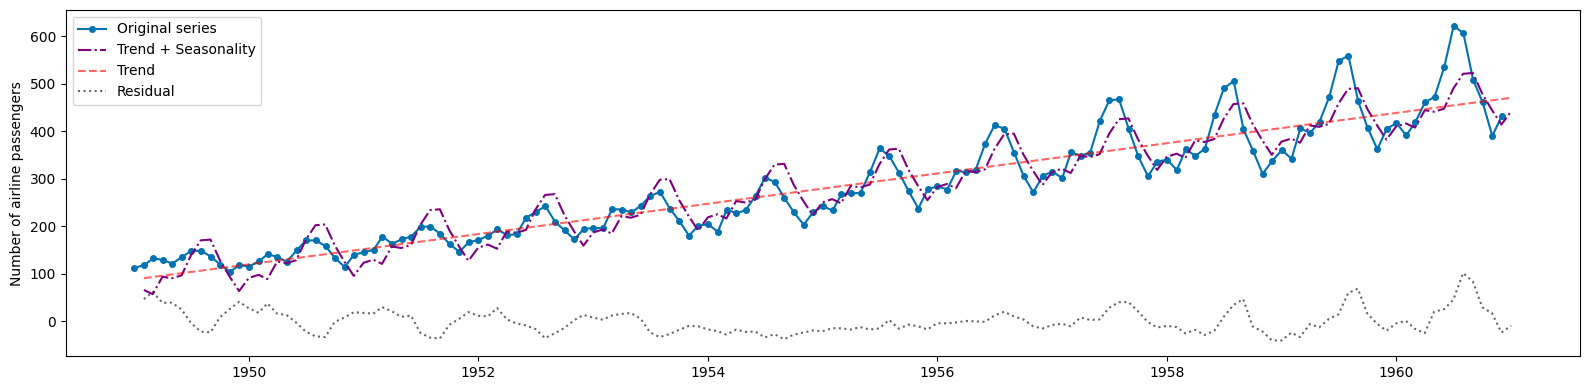

In [70]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual)

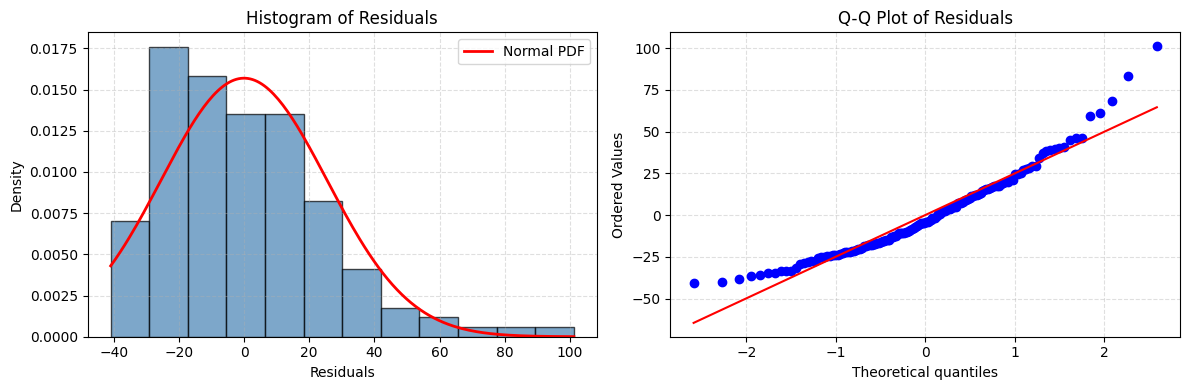

In [71]:
plot_residuals(residual)

##### Using pipelines

In [72]:
from sktime.transformations.compose import TransformerPipeline

In [73]:
y = load_airline()

pipe = TransformerPipeline(steps=[
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
])

residual = pipe.fit_transform(y)

# Get trend
detrender = pipe.steps_[0][1]
y_detrended = detrender.transform(y)
trend = y - y_detrended

# seasonality:
deseasonalizer = pipe.steps_[1][1]
seasonality = y_detrended - deseasonalizer.transform(y_detrended)

# Residual:
residual = y - (trend + seasonality)

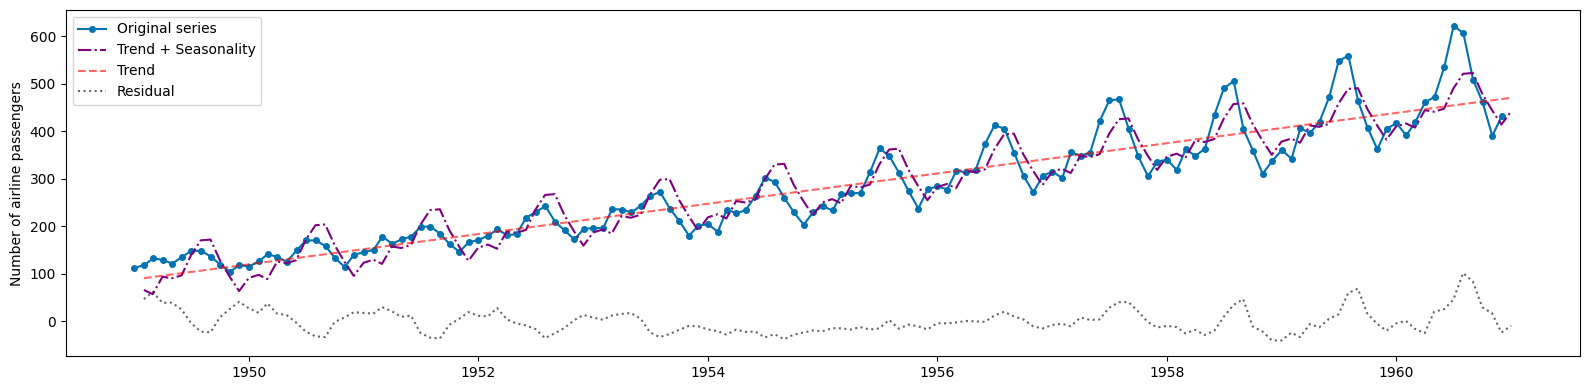

In [74]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual)

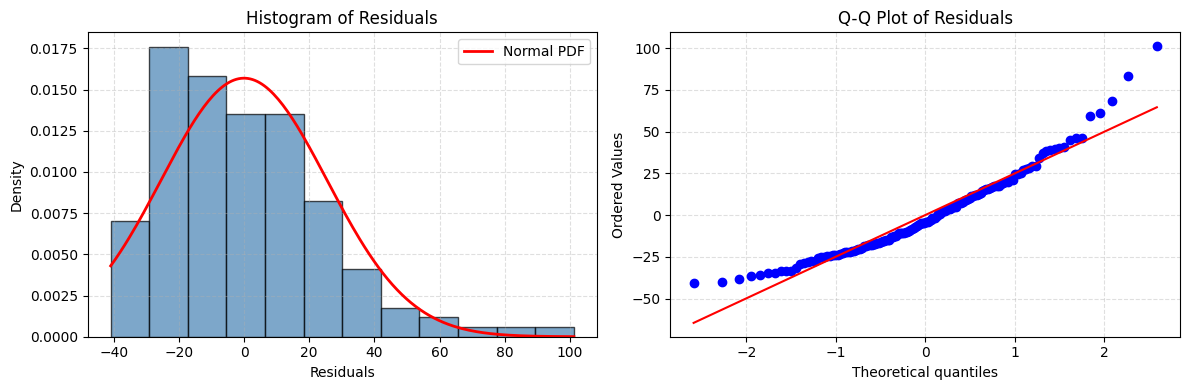

In [75]:
plot_residuals(residual)

#### Example: Multiplicative decomposition

In [85]:
y = load_airline()

# trend 
trend_forecaster = PolynomialTrendForecaster(degree=1)
detrender = Detrender(forecaster=trend_forecaster)
trend = trend_forecaster.fit(y).predict(fh=y.index)
y_detrended = y / trend

# Seasonality
deseasonalizer = Deseasonalizer(sp=12, model="multiplicative")
seasonality = y_detrended / deseasonalizer.fit_transform(y_detrended)

# Residual
residual = y / (trend * seasonal_component)

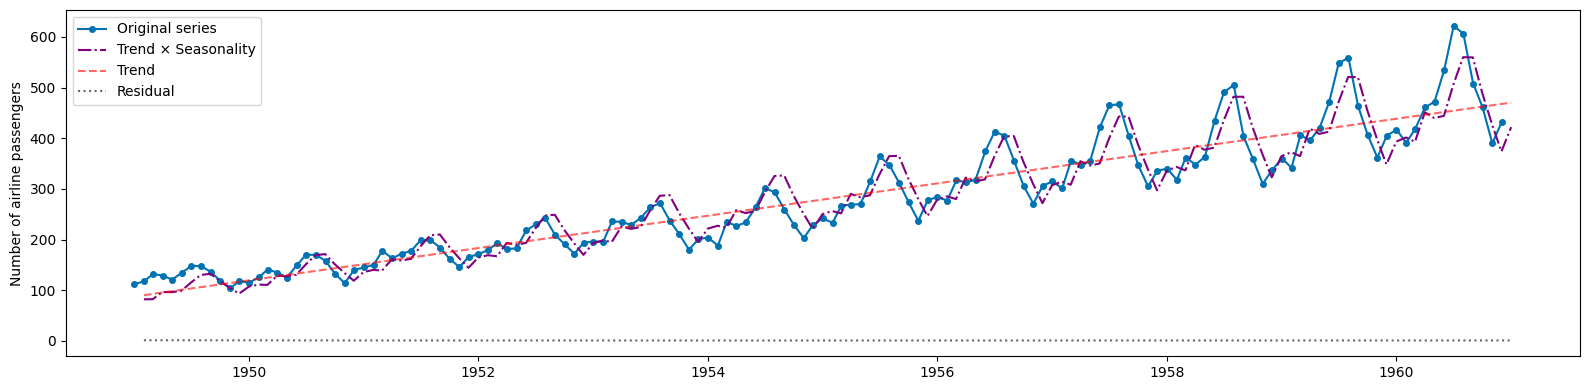

In [86]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual, model="multiplicative")

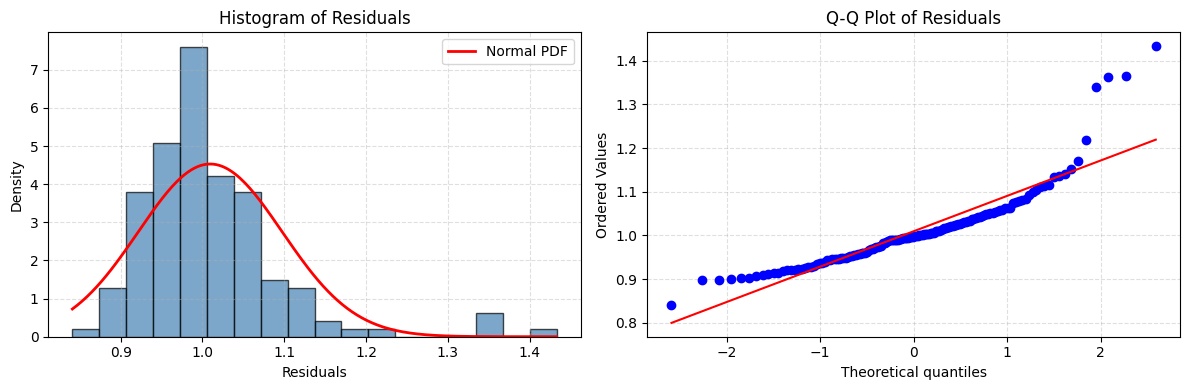

In [87]:
plot_residuals(residual)

#### Other advanced decomposition methods: X-11 and SEATS

Classical decomposition is a simple and useful exploratory tool, but it has drawbacks:

- The trend estimate is unavailable for the first and last few data points.
- It assumes the seasonal component repeats exactly from year to year.
- It is sensitive to outliers.

More advanced methods have been developed to overcome these issues, with [X-13-ARIMA-SEATS](https://www.census.gov/data/software/x13as.html) (from the US Census Bureau) and [TRAMO-SEATS](https://es.wikipedia.org/wiki/TRAMO-SEATS) (from the **Bank of Spain**) being the industry standard for official statistics.

**Key advantages** of these methods include:

- Better End-Point Handling: They "recover" the lost data at the ends of the trend component.
- Evolving Seasonality: The seasonal component is allowed to change gradually over time.
- Robustness: They can handle calendar effects (trading days, moving holidays) and outliers as part of the decomposition process.

These methods are available through `statsmodels` and can be integrated into an `sktime` workflow for more robust seasonal adjustment and analysis.

#### Automated with STL: Seasonal and trend decomposition using Loess


STL is a versatile and robust method for decomposing a time series into its trend, seasonal, and residual components. It was developed by R. B. Cleveland et al. and represents a significant advancement over classical decomposition methods. The name "STL" is an acronym for "Seasonal and Trend decomposition using Loess," where Loess is the key to its flexibility.

STL can handle any type of seasonality (not just monthly or quarterly) and the seasonal component is allowed to change over time. Its most significant advantage comes from the use of **Loess** (Locally Estimated Scatterplot Smoothing), a non-parametric regression method.

Instead of fitting a single polynomial to the entire dataset to find the trend, Loess fits numerous simple linear models on small, localized subsets of the data. This allows it to capture complex and changing patterns without making rigid assumptions about the data's underlying structure.

Key advantages of STL include:
* **Robustness to outliers**: STL includes an outer loop that iteratively calculates "robustness weights" to reduce the influence of outliers on the final decomposition.
* **Flexibility**: It can decompose series with complex or changing seasonal patterns.
* **Control**: The user can control the smoothness of the trend and the rate of change in the seasonal component.

##### Bonus: An intuitive overview of the STL algorithm

STL uses a two-loop procedure:

1.  **The Inner Loop**: Iteratively separates the trend and seasonal components.
    * **(a) Detrending**: An initial trend estimate is subtracted from the series.
    * **(b) Cycle-Subseries Smoothing**: The detrended series is broken down into seasonal sub-series (e.g., all the January values, all the February values, etc.). Loess is then applied to smooth each of these sub-series.
    * **(c) Filtering**: The collection of smoothed sub-series is filtered to produce the final seasonal component for this iteration.
    * **(d) Detrending again**: The seasonal component is subtracted from the original series, and Loess is applied to smooth the result to find the trend component for this iteration.

2.  **The Outer Loop**: This is what provides robustness.
    * After an inner loop completes, the residuals ($y_t - \tau_t - \sigma_t$) are calculated.
    * Large residuals (potential outliers) are identified, and "robustness weights" are calculated for each data point. Points with large residuals are given small (or zero) weights.
    * The entire inner loop is then repeated, but this time the Loess smoothing steps use these weights, effectively downplaying the influence of outliers. This outer loop is typically repeated a few times.


##### Example: Decomposing atmospheric CO2 from continuous air samples

In [191]:
from sktime.datasets import load_airline
from sktime.transformations.series.detrend import STLTransformer

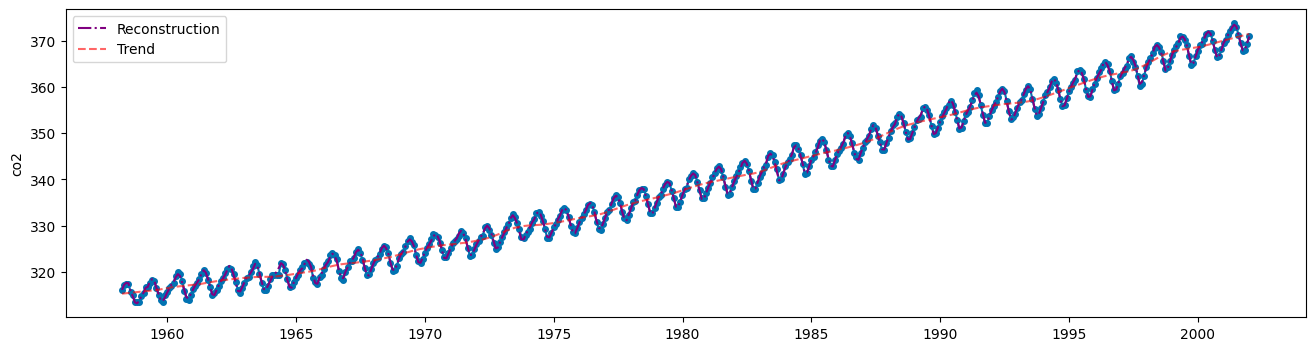

In [190]:
from statsmodels.datasets import co2

y = co2.load().data.resample('ME').mean().ffill()

transformer = STLTransformer(sp=12, return_components=True)  
y_t = transformer.fit_transform(y)  

fig, ax = plot_series(y)
ax.plot(y_t.trend + y_t.seasonal, color="purple", linestyle="-.", label="Reconstruction")
ax.plot(y_t.trend, color="red", linestyle="--", alpha=0.6, label="Trend")
plt.legend()
plt.show()

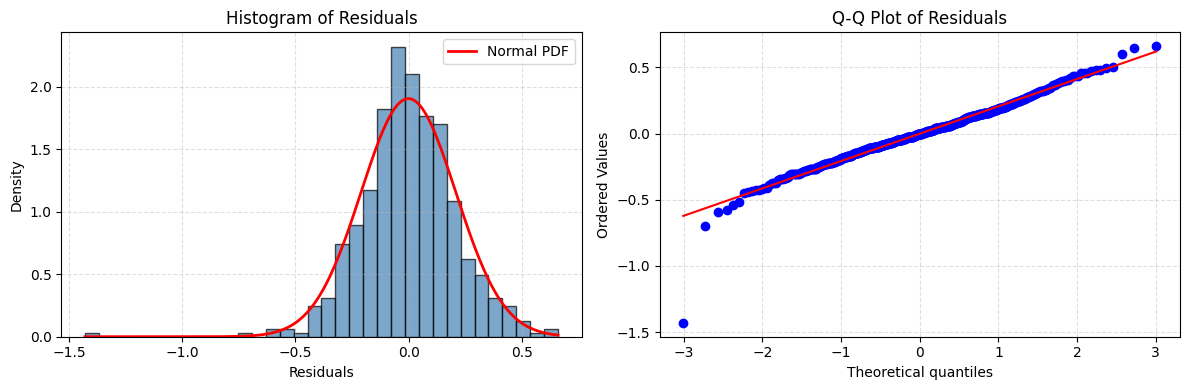

In [145]:
plot_residuals(y_t.resid)

##### Example: Decomposing Australia's electricty demand 

In [194]:
from sktime.transformations.series.detrend.mstl import MSTL

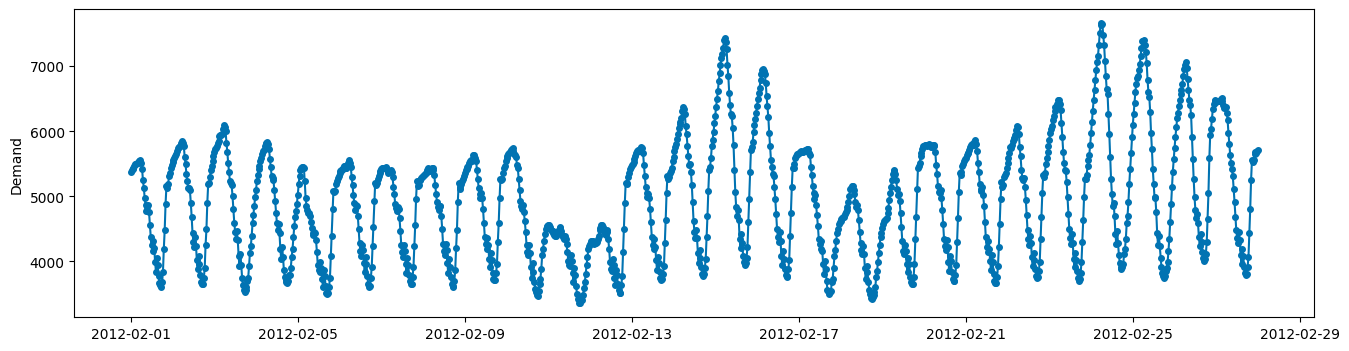

In [195]:
electricity_df = ExampleDataLoader("electricity").load().set_index("Time")
electricity_df.index

y = plot_series_slice(
    electricity_df["Demand"],
    start="2012-02-01 00:00:00+00:00",
    stop="2012-02-28 00:00:00+00:00",
    freq="30 min",
    return_data=True
)

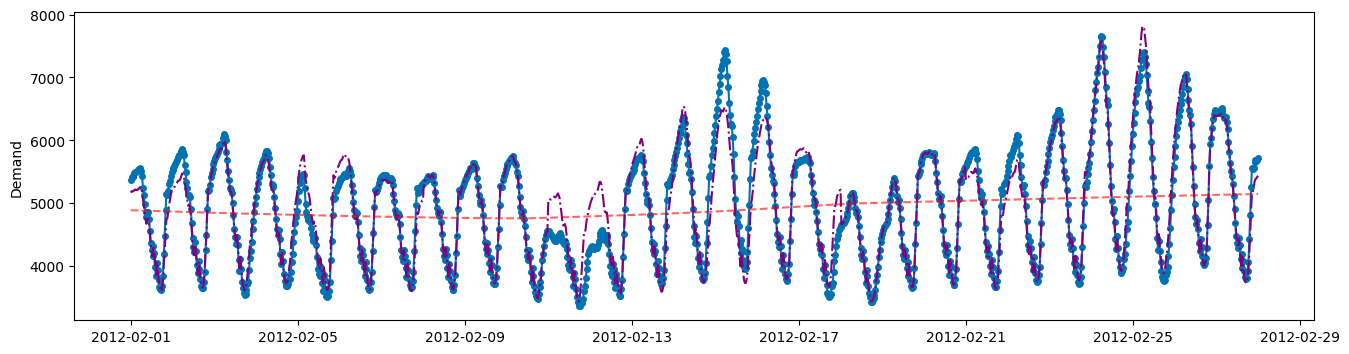

In [188]:
transformer = STLTransformer(sp=24*20, return_components=True)  
y_t = transformer.fit_transform(y)  

fig, ax = plot_series(y)
ax.plot(y_t.trend + y_t.seasonal, color="purple", linestyle="-.", label="Reconstruction")
ax.plot(y_t.trend, color="red", linestyle="--", alpha=0.6, label="Trend")

In [217]:
transformer = MSTL(periods=[24, 24*7], return_components=True)
y_t = transformer.fit_transform(y)  
y_t.head(5)

,trend,resid,seasonal_24,seasonal_168
2012-02-01 00:00:00+00:00,5122.836824,232.540988,-289.045005,306.466394
2012-02-01 00:30:00+00:00,5120.444990,266.119958,-276.782853,298.954301
2012-02-01 01:00:00+00:00,5118.055893,233.655086,-188.901324,256.967580
2012-02-01 01:30:00+00:00,5115.669531,271.066930,-196.925170,246.381832
2012-02-01 02:00:00+00:00,5113.285894,327.549816,-228.341312,260.373215
